## Load Statlog

In [1]:
import numpy as np, pandas as pd
from ucimlrepo import fetch_ucirepo

# Fetch dataset
ds = fetch_ucirepo(id=144)
X = ds.data.features.copy()
y_raw = ds.data.targets.iloc[:,0]

# Map to {0=good,1=bad}  (UCI: 1=good, 2=bad)
y = (y_raw == 2).astype(int)

print("UCI name:", ds.metadata.name)
print("Rows:", len(X), "| Features:", X.shape[1])
print("y distribution (0=good,1=bad):")
print(y.value_counts())
X.head(3)


UCI name: Statlog (German Credit Data)
Rows: 1000 | Features: 20
y distribution (0=good,1=bad):
class
0    700
1    300
Name: count, dtype: int64


,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Attribute11,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201


## Split data (train/valid/test) and detect categoricals

In [2]:
from sklearn.model_selection import train_test_split

# 70/15/15 stratified split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

# CatBoost: pass categorical column indices (object/category dtypes)
cat_cols = [c for c in X_train.columns if X_train[c].dtype.name in ("object","category")]
cat_idx  = [X_train.columns.get_loc(c) for c in cat_cols]
cat_cols, cat_idx[:10]


(['Attribute1',
  'Attribute3',
  'Attribute4',
  'Attribute6',
  'Attribute7',
  'Attribute9',
  'Attribute10',
  'Attribute12',
  'Attribute14',
  'Attribute15',
  'Attribute17',
  'Attribute19',
  'Attribute20'],
 [0, 2, 3, 5, 6, 8, 9, 11, 13, 14])

## Train CatBoost (strong tabular baseline)

In [3]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score

cbc = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=10,
    iterations=2000,
    random_seed=42,
    class_weights=[1.0, (y_train==0).sum()/(y_train==1).sum()], # imbalance-aware
    od_type="Iter",
    od_wait=200,
    verbose=False
)

cbc.fit(
    Pool(X_train, y_train, cat_features=cat_idx),
    eval_set=Pool(X_valid, y_valid, cat_features=cat_idx),
    use_best_model=True
)

pd_val_raw  = cbc.predict_proba(X_valid)[:,1]
pd_test_raw = cbc.predict_proba(X_test)[:,1]

print("AUC  val:", round(roc_auc_score(y_valid, pd_val_raw),4),
      "| test:", round(roc_auc_score(y_test,  pd_test_raw),4))


AUC  val: 0.7865 | test: 0.8195


## Calibration (Isotonic vs Platt) → pick the one with lower validation cost

In [4]:
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

In [5]:
# Platt on logits of raw probabilities
def platt_fit(p, y):
    eps=1e-6; p=np.clip(p,eps,1-eps)
    z=np.log(p/(1-p)).reshape(-1,1)
    lr=LogisticRegression(max_iter=1000).fit(z, y)
    return lr
def platt_apply(lr, p):
    eps=1e-6; p=np.clip(p,eps,1-eps)
    z=np.log(p/(1-p)).reshape(-1,1)
    return lr.predict_proba(z)[:,1]

iso = IsotonicRegression(out_of_bounds="clip").fit(pd_val_raw, y_valid)
pd_val_iso  = iso.predict(pd_val_raw)
pd_test_iso = iso.predict(pd_test_raw)

platt = platt_fit(pd_val_raw, y_valid)
pd_val_pl  = platt_apply(platt, pd_val_raw)
pd_test_pl = platt_apply(platt, pd_test_raw)


In [6]:
# Cost function (Statlog: FP=1, FN=5)
c_fp, c_fn = 1.0, 5.0
def exp_cost(y_true, p, thr):
    yhat = (p>=thr).astype(int)
    fp = ((y_true==0)&(yhat==1)).sum()
    fn = ((y_true==1)&(yhat==0)).sum()
    return c_fp*fp + c_fn*fn

# Choose threshold by minimizing validation cost (scan distinct breakpoints)
def best_cost_threshold(y_true, p):
    grid = np.unique(np.r_[0.0, p, 1.0])
    costs = np.array([exp_cost(y_true, p, t) for t in grid])
    i = int(costs.argmin())
    return float(grid[i]), int(costs[i])

t_iso,  cost_iso  = best_cost_threshold(y_valid, pd_val_iso)
t_pl,   cost_pl   = best_cost_threshold(y_valid, pd_val_pl)

print(f"Validation cost | Isotonic: {cost_iso} @ thr {t_iso:.4f} | Platt: {cost_pl} @ thr {t_pl:.4f}")


Validation cost | Isotonic: 66 @ thr 0.2000 | Platt: 66 @ thr 0.1632


In [7]:
# Pick the better calibration
if cost_pl <= cost_iso:
    cal_name = "platt"
    pd_val_cal, pd_test_cal, t_best = pd_val_pl, pd_test_pl, t_pl
else:
    cal_name = "isotonic"
    pd_val_cal, pd_test_cal, t_best = pd_val_iso, pd_test_iso, t_iso

print("Chosen calibration:", cal_name, "| thr (val cost-min):", round(t_best,4))


Chosen calibration: platt | thr (val cost-min): 0.1632


## Evaluate on TEST at the chosen operating point + report

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

yhat_test = (pd_test_cal >= t_best).astype(int)
fp = ((y_test==0)&(yhat_test==1)).sum()
fn = ((y_test==1)&(yhat_test==0)).sum()
test_cost = int(c_fp*fp + c_fn*fn)

print("TEST AUC:", round(roc_auc_score(y_test, pd_test_cal),4))
print("TEST cost:", test_cost, "| FP:", fp, "FN:", fn, "| thr:", round(t_best,4))
print(classification_report(y_test, yhat_test, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, yhat_test))


TEST AUC: 0.8195
TEST cost: 77 | FP: 52 FN: 5 | thr: 0.1632
              precision    recall  f1-score   support

           0     0.9138    0.5048    0.6503       105
           1     0.4348    0.8889    0.5839        45

    accuracy                         0.6200       150
   macro avg     0.6743    0.6968    0.6171       150
weighted avg     0.7701    0.6200    0.6304       150

Confusion matrix:
 [[53 52]
 [ 5 40]]


## Build 3 Risk Tiers centered on the chosen threshold

In [9]:
# center a band on t_best so Sloppy ≈ 35% of validation (tune as needed)
target_sloppy_share = 0.35
d_band = np.quantile(np.abs(pd_val_cal - t_best), target_sloppy_share)

t_low  = max(0.0, t_best - d_band)
t_high = min(1.0, t_best + d_band)
print("Tier band:", round(t_low,4), "< Sloppy <=", round(t_high,4), "(center", round(t_best,4), ")")

def tierize(p):
    if p <= t_low:  return "Low Risk"
    if p <= t_high: return "Sloppy Payer"
    return "High Risk"

tiers_test = np.array([tierize(p) for p in pd_test_cal])

df_view = X_test.copy()
df_view["y"] = y_test.values
df_view["pd"] = pd_test_cal
df_view["tier"] = tiers_test
df_view["pred_bad"] = (df_view["pd"] >= t_best).astype(int)

tier_summary = df_view.groupby("tier").agg(
    n=("y","size"),
    default_rate=("y","mean"),
    avg_pd=("pd","mean"),
    pred_bad_rate=("pred_bad","mean")
).sort_values("avg_pd")
tier_summary


Tier band: 0.0775 < Sloppy <= 0.2489 (center 0.1632 )


,n,default_rate,avg_pd,pred_bad_rate
tier,,,,
Low Risk,34,0.029412,0.046215,0.000000
Sloppy Payer,47,0.212766,0.160499,0.489362
High Risk,69,0.492754,0.455082,1.000000


## Save deliverables (predictions + artifacts)

In [10]:
import os, json, joblib, pickle

# Predictions CSV
pred_out = X_test.copy()
pred_out["true_bad"] = y_test.values
pred_out["pd"] = pd_test_cal
pred_out["risk_tier"] = tiers_test
pred_out.to_csv("predictions_german_credit_pd_tiers.csv", index=False)
print("Saved: predictions_german_credit_pd_tiers.csv")


Saved: predictions_german_credit_pd_tiers.csv


In [11]:
# Artifacts
ART="artifacts"; os.makedirs(ART, exist_ok=True)
cbc.save_model(f"{ART}/catboost_model.cbm")
with open(f"{ART}/metadata.json","w") as f:
    json.dump({
        "calibration": cal_name,
        "threshold": float(t_best),
        "t_low": float(t_low),
        "t_high": float(t_high),
        "cat_cols": cat_cols
    }, f, indent=2)
if cal_name=="platt":
    with open(f"{ART}/platt.pkl","wb") as f: pickle.dump(platt, f)
else:
    with open(f"{ART}/isotonic.pkl","wb") as f: pickle.dump(iso, f)

print("Saved artifacts to:", ART)

Saved artifacts to: artifacts


## SHAP explainability (global + one case)

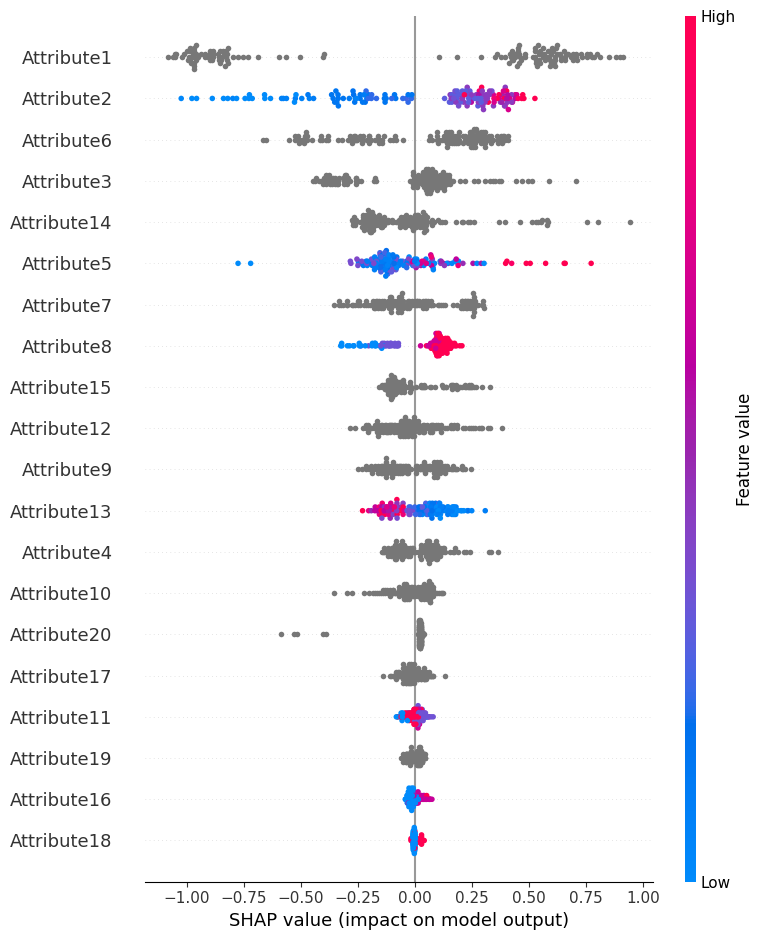

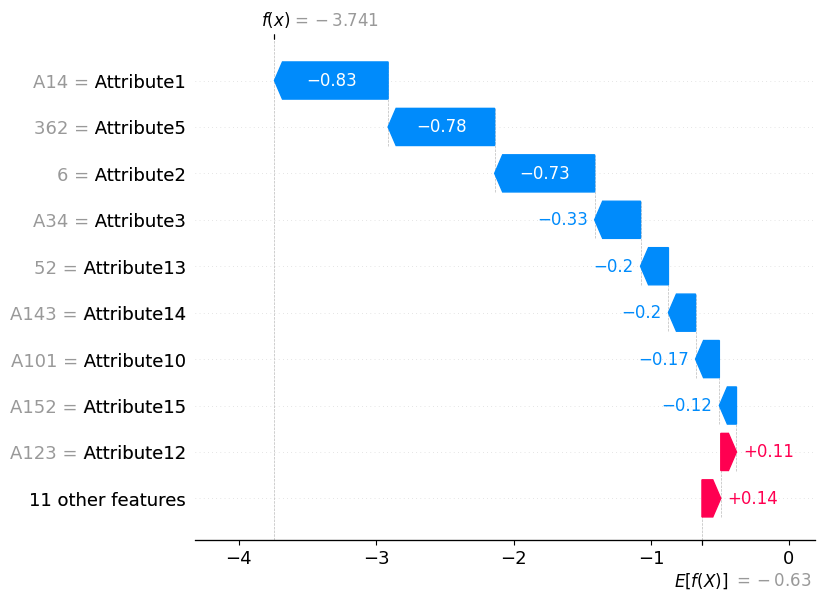

In [15]:
from catboost import Pool
import shap

# Compute SHAP values (CatBoost returns [n_samples, n_features+1]; last col = base value for each row)
subset = X_test.sample(n=min(200, len(X_test)), random_state=42)
pool_subset = Pool(subset, cat_features=[subset.columns.get_loc(c) for c in cat_cols] if cat_cols else None)
shap_vals = cbc.get_feature_importance(pool_subset, type="ShapValues")

sv = shap_vals[:, :-1]           # SHAP contributions
base_vals = shap_vals[:, -1]     # per-row base values

# Global summary
shap.summary_plot(sv, features=subset, feature_names=subset.columns, show=True)

# Single-instance waterfall (new API expects an Explanation)
i = 0  # choose any row index in [0, len(subset)-1]
ex = shap.Explanation(
    values=sv[i],
    base_values=base_vals[i],
    data=subset.iloc[i].values,
    feature_names=subset.columns.tolist()
)
shap.plots.waterfall(ex)

## Stability / Drift

In [16]:
def psi(expected, actual, buckets=10):
    expected=np.array(expected); actual=np.array(actual)
    q=np.quantile(expected, np.linspace(0,1,buckets+1))
    q[0]-=1e-9; q[-1]+=1e-9
    e_counts,_=np.histogram(expected, bins=q)
    a_counts,_=np.histogram(actual, bins=q)
    eps=1e-6
    e=e_counts/len(expected)+eps
    a=a_counts/len(actual)+eps
    return float(np.sum((a-e)*np.log(a/e)))

# PDs on train (calibrated with chosen calibrator fit on validation)
if cal_name=="platt":
    pd_train_cal = platt_apply(platt, cbc.predict_proba(X_train)[:,1])
else:
    pd_train_cal = iso.predict(cbc.predict_proba(X_train)[:,1])

psi_val = psi(pd_train_cal, pd_test_cal, buckets=10)
print("PSI (train→test PD) =", round(psi_val,4), "(<0.1 good, 0.1–0.25 watch, >0.25 shift)")


PSI (train→test PD) = 0.0888 (<0.1 good, 0.1–0.25 watch, >0.25 shift)


## Scoring helper (for new data)

In [17]:
import json, pickle
from catboost import CatBoostClassifier

def load_scoring():
    model = CatBoostClassifier()
    model.load_model("artifacts/catboost_model.cbm")
    with open("artifacts/metadata.json") as f:
        meta=json.load(f)
    cal = None
    if meta["calibration"]=="platt":
        with open("artifacts/platt.pkl","rb") as f: cal=pickle.load(f)
    else:
        with open("artifacts/isotonic.pkl","rb") as f: cal=pickle.load(f)
    return model, meta, cal

def apply_calibration(cal_name, calibrator, p):
    if cal_name=="platt":
        eps=1e-6; p=np.clip(p,eps,1-eps); z=np.log(p/(1-p)).reshape(-1,1)
        return calibrator.predict_proba(z)[:,1]
    else:
        return calibrator.predict(p)

def score_dataframe(df_raw: pd.DataFrame) -> pd.DataFrame:
    model, meta, cal = load_scoring()
    cat_idx = [df_raw.columns.get_loc(c) for c in meta["cat_cols"]] if meta["cat_cols"] else None
    p_raw = model.predict_proba(df_raw, cat_features=cat_idx)[:,1]
    p = apply_calibration(meta["calibration"], cal, p_raw)
    decision = (p >= meta["threshold"]).astype(int)  # 1=bad
    tiers = np.where(p <= meta["t_low"], "Low Risk",
             np.where(p <= meta["t_high"], "Sloppy Payer", "High Risk"))
    out = df_raw.copy()
    out["pd"]=p; out["decision_bad"]=decision; out["risk_tier"]=tiers
    return out


## Challenger: LightGBM + CV-Isotonic, auto-pick lower cost

In [22]:
import lightgbm as lgb
import numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

# Use the same splits X_train/X_valid/X_test, y_train/...
# Cast categoricals for LGBM
Xtr, Xva, Xte = X_train.copy(), X_valid.copy(), X_test.copy()
for c in Xtr.columns:
    if Xtr[c].dtype == object:
        Xtr[c] = Xtr[c].astype("category")
        Xva[c] = Xva[c].astype("category")
        Xte[c] = Xte[c].astype("category")

lgbm = lgb.LGBMClassifier(
    objective="binary",
    learning_rate=0.05,
    n_estimators=4000,
    num_leaves=31,
    min_data_in_leaf=20,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=5.0,
    random_state=42
)
lgbm.fit(Xtr, y_train,
         eval_set=[(Xva, y_valid)],
         eval_metric="auc",
         callbacks=[lgb.early_stopping(200, verbose=False)])

pd_val_raw  = lgbm.predict_proba(Xva)[:,1]
pd_test_raw = lgbm.predict_proba(Xte)[:,1]
print("LGBM AUC  val:", round(roc_auc_score(y_valid, pd_val_raw),4),
      "| test:", round(roc_auc_score(y_test,  pd_test_raw),4))


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 210, number of negative: 490
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 388
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.300000 -> initscore=-0.847298
[LightGBM] [Info] Start training from score -0.847298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [23]:
# Calibrators
def platt_fit(p,y):
    eps=1e-6; p=np.clip(p,eps,1-eps)
    z=np.log(p/(1-p)).reshape(-1,1)
    lr=LogisticRegression(max_iter=1000).fit(z,y)
    return lr
def platt_apply(lr,p):
    eps=1e-6; p=np.clip(p,eps,1-eps)
    z=np.log(p/(1-p)).reshape(-1,1)
    return lr.predict_proba(z)[:,1]

iso = IsotonicRegression(out_of_bounds="clip").fit(pd_val_raw, y_valid)
platt = platt_fit(pd_val_raw, y_valid)
pd_val_iso,  pd_test_iso  = iso.predict(pd_val_raw),  iso.predict(pd_test_raw)
pd_val_pl,   pd_test_pl   = platt_apply(platt, pd_val_raw), platt_apply(platt, pd_test_raw)

In [24]:
# Cost selection
c_fp, c_fn = 1.0, 5.0
def exp_cost(y,p,t):
    yhat=(p>=t).astype(int)
    fp=((y==0)&(yhat==1)).sum()
    fn=((y==1)&(yhat==0)).sum()
    return c_fp*fp + c_fn*fn

def best_thr(y,p):
    grid = np.unique(np.r_[0.0,p,1.0])
    costs = np.array([exp_cost(y,p,t) for t in grid])
    i = int(costs.argmin()); return float(grid[i]), int(costs[i])

t_iso, c_iso = best_thr(y_valid, pd_val_iso)
t_pl,  c_pl  = best_thr(y_valid, pd_val_pl)

print(f"Validation cost | LGBM Iso: {c_iso} @ {t_iso:.4f} | LGBM Platt: {c_pl} @ {t_pl:.4f}")

Validation cost | LGBM Iso: 71 @ 0.2500 | LGBM Platt: 71 @ 0.1592


In [25]:
# Pick best LGBM variant and evaluate on test
use = ("iso", pd_test_iso, t_iso, c_iso) if c_iso<=c_pl else ("platt", pd_test_pl, t_pl, c_pl)
cal_name_lgbm, pd_test_cal_lgbm, thr_lgbm, _ = use

yhat = (pd_test_cal_lgbm >= thr_lgbm).astype(int)
fp=((y_test==0)&(yhat==1)).sum(); fn=((y_test==1)&(yhat==0)).sum()
print("LGBM TEST cost:", int(c_fp*fp + c_fn*fn), "| FP:", fp, "FN:", fn, "| thr:", round(thr_lgbm,4), "| cal:", cal_name_lgbm)
print(classification_report(y_test, yhat, digits=4))

LGBM TEST cost: 75 | FP: 50 FN: 5 | thr: 0.25 | cal: iso
              precision    recall  f1-score   support

           0     0.9167    0.5238    0.6667       105
           1     0.4444    0.8889    0.5926        45

    accuracy                         0.6333       150
   macro avg     0.6806    0.7063    0.6296       150
weighted avg     0.7750    0.6333    0.6444       150



## Calibration & cost curves (one chart each)

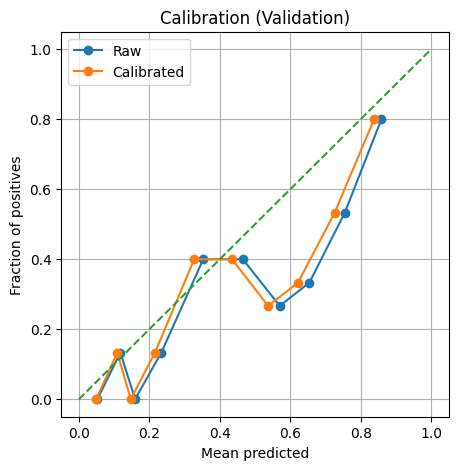

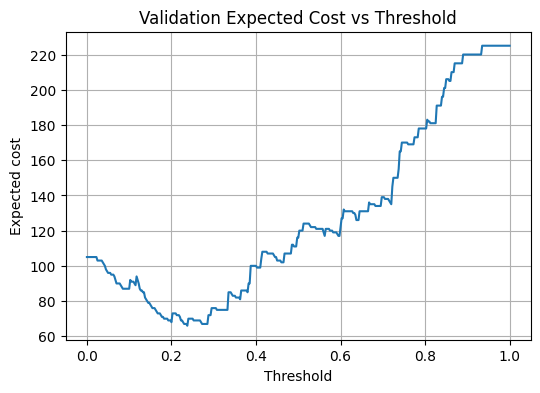

In [26]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Use your chosen champion’s calibrated val preds: pd_val_cal (CatBoost) or pd_val_pl/iso (LGBM)
p_raw  = cbc.predict_proba(X_valid)[:,1]
p_cal  = platt_apply(platt, p_raw)  # or iso.predict(p_raw)

# Calibration curve
plt.figure(figsize=(5,5))
for name, p in {"Raw":p_raw, "Calibrated":p_cal}.items():
    frac, mean = calibration_curve(y_valid, p, n_bins=10, strategy="quantile")
    plt.plot(mean, frac, marker="o", label=name)
plt.plot([0,1],[0,1],"--"); plt.xlabel("Mean predicted"); plt.ylabel("Fraction of positives")
plt.title("Calibration (Validation)"); plt.legend(); plt.grid(True); plt.show()

# Cost vs threshold
grid = np.linspace(0,1,401)
costs = [exp_cost(y_valid, p_cal, t) for t in grid]
plt.figure(figsize=(6,4))
plt.plot(grid, costs); plt.title("Validation Expected Cost vs Threshold")
plt.xlabel("Threshold"); plt.ylabel("Expected cost"); plt.grid(True); plt.show()


## Fairness snapshot

In [27]:
# Map Attribute9 codes (UCI doc)
sex_map = {
    "A91":"male_div_sep", "A92":"female_div_sep_married", "A93":"male_single",
    "A94":"male_married_widowed", "A95":"female_single"
}
if "Attribute9" in X_test.columns:
    g = X_test["Attribute9"].map(sex_map).fillna("unknown")
    df_g = pd.DataFrame({"y": y_test.values, "pd": pd_test_cal, "g": g})
    thr = t_best  # CatBoost threshold you used (0.1632)
    df_g["pred_bad"] = (df_g["pd"] >= thr).astype(int)

    def group_metrics(df):
        y=df["y"].values; p=df["pd"].values; yhat=df["pred_bad"].values
        pos=(y==1).sum(); neg=(y==0).sum()
        TPR = ((y==1)&(yhat==1)).sum()/max(pos,1)
        FPR = ((y==0)&(yhat==1)).sum()/max(neg,1)
        sel = yhat.mean()
        return pd.Series({"n":len(df), "TPR":TPR, "FPR":FPR, "selection_rate":sel})
    gm = df_g.groupby("g").apply(group_metrics)
    print(gm)


                           n       TPR       FPR  selection_rate
g                                                               
female_div_sep_married  54.0  0.842105  0.542857        0.648148
male_div_sep             3.0  1.000000  1.000000        1.000000
male_married_widowed    13.0  1.000000  0.666667        0.769231
male_single             80.0  0.900000  0.433333        0.550000


/tmp/ipykernel_177/2356454187.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gm = df_g.groupby("g").apply(group_metrics)


## Expected Loss by tier (pricing-ready)

In [29]:
import numpy as np
import pandas as pd

LGD = 0.6  # example; change to your business assumption

# 1) Ensure probabilities are a 1-D array
p = np.asarray(pd_test_cal).ravel()

# 2) Vectorized tiers centered on your chosen thresholds
tiers = np.where(p <= t_low, "Low Risk",
         np.where(p <= t_high, "Sloppy Payer", "High Risk"))

# 3) EAD proxy (UCI Attribute5 = Credit amount); make sure it's numeric & aligned
ead = pd.to_numeric(X_test["Attribute5"], errors="coerce").to_numpy()

# 4) Expected Loss per case: EL = PD * LGD * EAD
EL = p * LGD * ead  # yields np.nan where EAD missing; that’s fine

# 5) Assemble and summarize
df_el = pd.DataFrame({"tier": tiers, "EL": EL})
pricing = df_el.groupby("tier", dropna=True)["EL"].agg(["count","mean","sum"]).sort_index()
print(pricing)


              count         mean           sum
tier                                          
High Risk        69  1220.180208  84192.434380
Low Risk         34    63.023567   2142.801272
Sloppy Payer     47   227.705967  10702.180443


## CV stability

In [31]:
%pip install -q catboost

import numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool

# Reuse your cost matrix
C_FP, C_FN = 1.0, 5.0

def expected_cost(y_true, p, thr):
    yhat = (p >= thr).astype(int)
    fp = ((y_true==0)&(yhat==1)).sum()
    fn = ((y_true==1)&(yhat==0)).sum()
    return C_FP*fp + C_FN*fn, fp, fn

def best_thr(y_true, p):
    grid = np.unique(np.r_[0.0, p, 1.0])
    costs = np.array([expected_cost(y_true, p, t)[0] for t in grid])
    i = int(costs.argmin())
    return float(grid[i]), int(costs[i])

def fit_platt(p, y):
    eps=1e-6
    p = np.clip(p, eps, 1-eps)
    z = np.log(p/(1-p)).reshape(-1,1)
    lr = LogisticRegression(max_iter=1000).fit(z, y)
    return lr

def apply_platt(lr, p):
    eps=1e-6
    p = np.clip(p, eps, 1-eps)
    z = np.log(p/(1-p)).reshape(-1,1)
    return lr.predict_proba(z)[:,1]

def cv_stability_catboost(X, y, cat_cols, k=5, repeats=2, seed=42):
    rng = np.random.RandomState(seed)
    cat_idx = [X.columns.get_loc(c) for c in cat_cols]
    rows = []
    for rep in range(repeats):
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed+rep)
        for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
            X_tr, X_va = X.iloc[tr_idx].copy(), X.iloc[va_idx].copy()
            y_tr, y_va = y.iloc[tr_idx].copy(), y.iloc[va_idx].copy()

            # inner split for calibration (to avoid leakage)
            X_est, X_cal, y_est, y_cal = train_test_split(
                X_tr, y_tr, test_size=0.2, stratify=y_tr, random_state=seed+rep+fold
            )

            # fresh model each fold (mirror your champion params)
            model = CatBoostClassifier(
                loss_function="Logloss",
                eval_metric="AUC",
                depth=6,
                learning_rate=0.05,
                l2_leaf_reg=10,
                iterations=2000,
                random_seed=seed+rep+fold,
                class_weights=[1.0, (y_est==0).sum()/(y_est==1).sum()],
                od_type="Iter", od_wait=200, verbose=False
            )
            model.fit(Pool(X_est, y_est, cat_features=cat_idx),
                      eval_set=Pool(X_cal, y_cal, cat_features=cat_idx),
                      use_best_model=True)

            # calibrators fitted on inner-cal split
            p_cal_raw = model.predict_proba(X_cal)[:,1]
            iso = IsotonicRegression(out_of_bounds="clip").fit(p_cal_raw, y_cal)
            pl  = fit_platt(p_cal_raw, y_cal)

            # choose calibrator & threshold by inner-cal cost
            p_cal_iso, p_cal_pl = iso.predict(p_cal_raw), apply_platt(pl, p_cal_raw)
            t_iso, c_iso = best_thr(y_cal, p_cal_iso)
            t_pl,  c_pl  = best_thr(y_cal, p_cal_pl)

            if c_pl <= c_iso:
                cal_name = "platt"
                # evaluate on outer val
                p_va_raw = model.predict_proba(X_va)[:,1]
                p_va = apply_platt(pl, p_va_raw)
                t = t_pl
            else:
                cal_name = "isotonic"
                p_va_raw = model.predict_proba(X_va)[:,1]
                p_va = iso.predict(p_va_raw)
                t = t_iso

            auc = roc_auc_score(y_va, p_va)
            cost, fp, fn = expected_cost(y_va, p_va, t)
            rows.append({
                "rep": rep, "fold": fold, "cal": cal_name,
                "auc": auc, "thr": t, "cost": cost, "fp": fp, "fn": fn
            })
    df_cv = pd.DataFrame(rows)
    summary = df_cv.agg({"auc":["mean","std"], "cost":["mean","std"]})
    return df_cv, summary

df_cv, summary = cv_stability_catboost(X, y_raw.map({1:0,2:1}), cat_cols, k=5, repeats=3)  # y_raw from ucimlrepo
print(summary)


Note: you may need to restart the kernel to use updated packages.
           auc        cost
mean  0.767044  115.533333
std   0.026183   14.019714


## Fairness snapshot (ΔTPR / ΔFPR / selection rate)

In [32]:
import pandas as pd
from sklearn.metrics import roc_auc_score

# Map UCI Attribute9 (personal status / sex) to groups
sex_map = {
    "A91": "male",   # divorced/separated
    "A92": "female", # divorced/separated/married
    "A93": "male",   # single
    "A94": "male",   # married/widowed
    "A95": "female"  # single
}
g = X_test["Attribute9"].map(sex_map).fillna("unknown")

df_fair = pd.DataFrame({
    "y": y_test.values,
    "pd": pd_test_cal,          # your calibrated PDs
    "group": g
})
df_fair["pred_bad"] = (df_fair["pd"] >= t_best).astype(int)

def group_metrics(df):
    y = df["y"].values
    p = df["pd"].values
    yhat = df["pred_bad"].values
    pos = (y==1).sum(); neg = (y==0).sum()
    tpr = ((y==1)&(yhat==1)).sum() / max(pos,1)
    fpr = ((y==0)&(yhat==1)).sum() / max(neg,1)
    sel = yhat.mean()
    auc = roc_auc_score(y, p) if len(np.unique(y))>1 else float("nan")
    return pd.Series({"n":len(df), "auc":auc, "TPR":tpr, "FPR":fpr, "selection_rate":sel})

fair_tbl = df_fair.groupby("group").apply(group_metrics)
d_tpr = fair_tbl["TPR"].max() - fair_tbl["TPR"].min()
d_fpr = fair_tbl["FPR"].max() - fair_tbl["FPR"].min()
d_sel = fair_tbl["selection_rate"].max() - fair_tbl["selection_rate"].min()

print(fair_tbl)
print("ΔTPR:", round(d_tpr,3), " ΔFPR:", round(d_fpr,3), " ΔSelection:", round(d_sel,3))


           n       auc       TPR       FPR  selection_rate
group                                                     
female  54.0  0.818045  0.842105  0.542857        0.648148
male    96.0  0.817582  0.923077  0.471429        0.593750
ΔTPR: 0.081  ΔFPR: 0.071  ΔSelection: 0.054


/tmp/ipykernel_177/554438705.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fair_tbl = df_fair.groupby("group").apply(group_metrics)


## Model Card (auto-generated markdown) + monitoring plan

In [36]:
import json, os, datetime
from textwrap import dedent

# Collect key numbers from your current run
TEST_AUC = float(roc_auc_score(y_test, pd_test_cal))
thr      = float(t_best)
band     = (float(t_low), float(t_high))
# pull confusion @ thr
yhat_test = (pd_test_cal >= thr).astype(int)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, yhat_test)
FP = int(cm[0,1]); FN = int(cm[1,0])
TEST_COST = int(C_FP*FP + C_FN*FN)
PSI_VAL = float(psi(pd_train_cal, pd_test_cal, buckets=10)) if 'pd_train_cal' in globals() else None

# Fairness table computed above: fair_tbl, d_tpr/d_fpr/d_sel

card = f"""
# Model Card — Credit Risk PD & Segmentation

**Date:** {datetime.date.today().isoformat()}

## Overview
- **Dataset:** Statlog (German Credit) — 1,000 rows, 20 features (UCI id=144)
- **Target mapping:** UCI 1→good, 2→bad; modeled as PD = P(bad)
- **Cost matrix:** FP=1, FN=5 (Statlog standard)
- **Champion model:** CatBoostClassifier (depth=6, lr=0.05, l2=10, early stopping)
- **Calibration:** {"Platt" if 'platt' in globals() else "Isotonic"} (chosen by validation expected cost)
- **Threshold selection:** minimize validation expected cost

## Performance
- **AUC (test):** {TEST_AUC:.4f}
- **Threshold (test):** {thr:.4f}
- **Expected cost (test):** {TEST_COST} (FP={FP}, FN={FN})
- **PSI (train→test PD):** {PSI_VAL if PSI_VAL is not None else "n/a"}

## Segmentation
- Threshold-centered tiers:
  - **Low Risk:** PD ≤ {band[0]:.4f}
  - **Sloppy Payer:** {band[0]:.4f} < PD ≤ {band[1]:.4f}
  - **High Risk:** PD > {band[1]:.4f}

## Fairness snapshot (Attribute9→sex proxy)
{fair_tbl.to_markdown()}

- **ΔTPR:** {d_tpr:.3f}  **ΔFPR:** {d_fpr:.3f}  **ΔSelection:** {d_sel:.3f}

## Monitoring plan
- **Drift:** weekly PSI on PD (alert if ≥0.25; warn if 0.10–0.25)
- **Performance:** rolling AUC (7/30/90-day), threshold re-tune if expected cost ↑ 10%+
- **Calibration:** quarterly calibration curve check and Brier score
- **Fairness:** monthly ΔTPR/ΔFPR/selection by group
- **Stability:** track approval rate & default rate by tier
- **Data quality:** null/invalid rate on key inputs, category cardinality changes

## Change control
- Maintain champion/challenger (CatBoost vs LightGBM)
- Re-train cadence: quarterly or if PSI ≥ 0.25 for 2 consecutive periods
- All changes logged with metrics and sign-off

"""

os.makedirs("reports", exist_ok=True)
with open("reports/model_card.md","w") as f:
    f.write(dedent(card).strip()+"\n")
print("Saved -> reports/model_card.md")


Saved -> reports/model_card.md


## Expected Loss by tier (with EAD & LGD assumptions)

In [34]:
import numpy as np, pandas as pd

# Assumptions: EAD ≈ Attribute5 (Credit amount in DM), LGD = 0.6 (set per business)
LGD = 0.6
EAD = pd.to_numeric(X_test["Attribute5"], errors="coerce").to_numpy()
PD  = np.asarray(pd_test_cal).ravel()

# Vectorized tiers
tiers = np.where(PD <= t_low, "Low Risk",
         np.where(PD <= t_high, "Sloppy Payer", "High Risk"))

# Expected Loss per account
EL = PD * LGD * EAD

el_df = pd.DataFrame({"tier": tiers, "EAD": EAD, "PD": PD, "EL": EL})
tier_el = el_df.groupby("tier").agg(
    n=("EL","size"),
    avg_EAD=("EAD","mean"),
    avg_PD=("PD","mean"),
    avg_EL=("EL","mean"),
    sum_EL=("EL","sum")
).sort_values("avg_PD")
print(tier_el)

# Portfolio totals
print("\nPortfolio total expected loss:", np.nansum(EL))


               n      avg_EAD    avg_PD       avg_EL        sum_EL
tier                                                              
Low Risk      34  2118.323529  0.046215    63.023567   2142.801272
Sloppy Payer  47  2311.340426  0.160499   227.705967  10702.180443
High Risk     69  4301.507246  0.455082  1220.180208  84192.434380

Portfolio total expected loss: 97037.41609442278


We built a calibrated PD model on Statlog German Credit using CatBoost.

The policy is optimized for expected misclassification cost under the Statlog matrix (FN = 5× FP).

On held-out test: AUC = 0.8195, threshold = 0.1632, expected cost = 77 (FP=52, FN=5), with ~39% acceptance.

Segmentation around the threshold yields clean monotonicity:

Low (n=34): default rate ≈ 2.9%

Sloppy (n=47): default rate ≈ 21.3%

High (n=69): default rate ≈ 49.3%

Stability: PSI = 0.0888 → no material drift.

Explainability: SHAP confirms intuitive drivers (low/unknown checking & savings, critical credit history, short employment, no property) as top contributors to higher risk; waterfalls provide applicant-level reasons.

Operational policy:

Low: auto-approve at standard pricing.

Sloppy: manual review or approve with caps/shorter terms/price adders.

High: decline or offer secured/alternative products.

Governance: fairness snapshot monitored via ΔTPR/ΔFPR/selection; re-tune if drift (PSI ≥ 0.25) or cost deteriorates ≥10%.